In [ ]:
%%sh
pip uninstall scikit-learn -y
pip install scikit-learn==0.20

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.0 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.0 which is incompatible.


In [2]:
%%sh
cp -r /content/drive/MyDrive/grmlab_0.6.0/grmlab /usr/local/lib/python3.7/dist-packages/

In [3]:
%%sh
pip uninstall scikit-learn -y
pip install scikit-learn==0.20

Found existing installation: scikit-learn 0.20.0
Uninstalling scikit-learn-0.20.0:
  Successfully uninstalled scikit-learn-0.20.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.20.0-cp37-cp37m-manylinux1_x86_64.whl (5.3 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.0 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.0 which is incompatible.


In [5]:
import pandas as pd
import glob
import os

path_google = '/content/drive/MyDrive/02Concursos/11InnovaEntel/datathon-entel-2022-reto1'
path = path_google + r'/04DB/01suscriptora/' # use your path
li = [path + 'suscriptora_202201.parquet',path + 'suscriptora_202202.parquet',path + 'suscriptora_202203.parquet',path + 'suscriptora_202204.parquet']

df_suscri = pd.concat(map(pd.read_parquet, li))
df_adenda = pd.read_parquet(path_google + '/04DB/02adenda/adenda.parquet')
df_digita = pd.read_parquet(path_google + '/04DB/03digital/digital.parquet')
df_roamin = pd.read_parquet(path_google + '/04DB/04roaming/roaming.parquet')
df_termin = pd.read_parquet(path_google + '/04DB/05terminal/terminal.parquet')
df_trafic = pd.read_parquet(path_google + '/04DB/06trafico/trafico.parquet')
df_conver = pd.read_parquet(path_google + '/04DB/07convergente/convergente.parquet')
df_target_new = pd.read_parquet(path_google + '/04DB/08target/target.parquet')
df_target = pd.read_parquet(path_google + '/01Data/02parquet/08_target_202201_202203.parquet')
df_target.columns =['numperiodo', 'nro_telefono_hash', 'target']

In [6]:
df_model = pd.merge(left=df_suscri,right= df_adenda,on=['numperiodo','nro_telefono_hash'],how='left')
df_model = pd.merge(left=df_model,right= df_digita,on=['numperiodo','nro_telefono_hash'],how='left')
df_model = pd.merge(left=df_model,right= df_roamin,on=['numperiodo','nro_telefono_hash'],how='left')
df_model = pd.merge(left=df_model,right= df_termin,on=['numperiodo','nro_telefono_hash'],how='left')
df_model = pd.merge(left=df_model,right= df_trafic,on=['numperiodo','nro_telefono_hash'],how='left')
df_model = pd.merge(left=df_model,right= df_conver,on=['numperiodo','nro_documento_hash'],how='left')
df_model = pd.merge(left=df_model,right= df_target,on=['numperiodo','nro_telefono_hash'],how='left')
df_model.rename(columns={'numperiodo':'periodo'},inplace=True)
df_model = pd.merge(left=df_model,right= df_target_new,on=['periodo','nro_telefono_hash'],how='left')

In [83]:
def prepare_df(df):
    df.set_index(['nro_documento_hash','nro_telefono_hash'],inplace=True)
    df.drop(columns=['fecingresocliente','fecactivacioncontrato','fechatraficomin','fechatraficomax','minutosstd','mensajesmean','mensajesstd','lanzamiento','target_new'],inplace =True)
    #df['target'] = df['target'].astype('int')
    return df

In [84]:
df = prepare_df(df_model.query('target_new >=0').copy())
df_test = prepare_df(df_model.query('periodo == 202201').copy())
df_leader = prepare_df(df_model.query('periodo == 202204').copy())

In [24]:
from grmlab.data_analysis import Univariate
special_values = [-99, -999, -9999, -99999]
variables_nominal = ['tipo_adq','tiposervicio','grupo','scorecat','tiposervicio','marca','modelo','nueva_gamma','os','device_type','giro','subgiro']
univariate = Univariate(target="target", date='periodo',special_values=special_values, variables_nominal=variables_nominal, verbose=True)

In [ ]:
univariate.run(data=df)

In [ ]:
univariate.results()[0]

In [ ]:
univariate.results()[1]

In [28]:
from grmlab.data_analysis import Bivariate
bivariate = Bivariate(target="target", date='periodo', special_values=special_values, variables_nominal=variables_nominal, verbose=True,monotonicity_force=False)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
bivariate.run(data=df)

In [55]:
from grmlab.data_processing.feature_binning import OptimalGrouping
optimal = OptimalGrouping(target='target', variables_nominal=variables_nominal, 
                          special_values=None, monotonicity_force=True, 
                          continuous_metric='mean', special_handler_policy='join', 
                          special_woe_policy='empirical', missing_woe_policy='empirical', 
                          optbin_options=None, verbose=False)

optimal.run(df.set_index('periodo'))
#df[select_var+['target']])

OptimalGrouping(
    continuous_metric='mean',
    missing_woe_policy='empirical',
    monotonicity_force=True,
    optbin_options=None,
    special_handler_policy='join',
    special_values=[],
    special_woe_policy='empirical',
    target='target',
    variables_nominal=['tipo_adq', 'tiposervicio', 'grupo', 'scorecat', 'tiposervicio', 'marca', 'modelo', 'nueva_gamma', 'os', 'device_type', 'giro', 'subgiro'],
    verbose=False)

In [56]:
df_woe = df.copy()
optimal.transform(df_woe)

In [57]:
df_woe_test = df_test.copy()
optimal.transform(df_woe_test)

In [89]:
df_woe_leader = df_model.copy()
optimal.transform(df_woe_leader)

In [90]:
df_woe_leader.to_parquet()

,periodo,fecingresocliente,nro_documento_hash,nro_telefono_hash,fecactivacioncontrato,tipo_adq,antiguedad_cliente,antiguedad_contrato,antiguedad_cliente_contrato,vchmesadenda,...,trafico_app_8,trafico_app_9,trafico_total,giro,subgiro,tiene_prod_1,tiene_prod_2,tiene_prod_3,target,target_new
0,202201,2011-03-02,5f58359a37ac456d9050c75aa36720b73063bf4b77f483...,9be57e3928a78ae85be270575f97e82a6bdbd59fc87281...,2018-12-07,0.0,-0.028106,-0.039029,0.0,-0.342285,...,0.050409,0.009141,-0.004570,-0.104649,-0.004325,-0.059512,0.0,0.0,0.0,NaN
1,202201,2005-08-31,ea411834dcd05b9e5eb4e1bed1a6b99250b33a4293fe46...,119dd6dff66e259a3996de7d885e2c54e8ed5874239346...,2018-12-13,0.0,-0.028106,-0.039029,0.0,-1.849581,...,0.050409,0.009141,-0.004570,0.024875,-0.004325,-0.059512,0.0,0.0,0.0,NaN
2,202201,2005-08-31,ea411834dcd05b9e5eb4e1bed1a6b99250b33a4293fe46...,73cec44593f362cccdb45773197a0bf2136978cb241c91...,2018-12-13,0.0,-0.028106,-0.039029,0.0,-0.342285,...,-0.313479,0.009141,-0.004570,0.024875,-0.004325,-0.059512,0.0,0.0,0.0,NaN
3,202201,2005-08-31,ea411834dcd05b9e5eb4e1bed1a6b99250b33a4293fe46...,db86e518af696d60b247466fd1bb5823cf81a9442c16b2...,2018-12-13,0.0,-0.028106,-0.039029,0.0,-0.342285,...,0.050409,0.009141,0.117913,0.024875,-0.004325,-0.059512,0.0,0.0,0.0,NaN
4,202201,2005-08-31,ea411834dcd05b9e5eb4e1bed1a6b99250b33a4293fe46...,90d5ab1ad28da36b0fa821759b0a9df2b248dc92a557a5...,2018-12-13,0.0,-0.028106,-0.039029,0.0,-0.342285,...,0.050409,0.009141,-0.004570,0.024875,-0.004325,-0.059512,0.0,0.0,0.0,NaN


In [33]:
df_woe['target'].value_counts()

0    5565
1    5290
Name: target, dtype: int64

In [34]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from grmlab.modelling.classification import GRMlabModelClassification
from grmlab.modelling.feature_selection import SelectOptimize
from grmlab.modelling.model_analysis import ModelAnalyzer
from grmlab.modelling.model_analysis import ModelComparison
from grmlab.modelling.model_optimization import ModelOptimizer

In [37]:
select_var = [ 'tipo_adq', 'antiguedad_cliente', 'antiguedad_contrato',
       'antiguedad_cliente_contrato', 'vchmesadenda', 'vchpenalidad',
       'con_adenda', 'grupo', 'scorecat', 'grupo_1', 'grupo_2', 'grupo_3',
       'grupo_4', 'grupo_5', 'grupo_6', 'grupo_7', 'grupo_8', 'grupo_9',
       'grupo_10', 'grupo_11', 'cant_grupos', 'tiposerviciocount',
       'minutossum', 'minutosmean', 'mensajessum', 'gigassum', 'gigasmean',
       'gigasstd', 'max_tiempo_interaccion', 'tiposervicio', 'marca', 'modelo',
       'nueva_gamma', 'os', 'device_type', 'antiguedad_lanzamiento',
       'mins_flujo_1', 'mins_flujo_2', 'trafico_app_1', 'trafico_app_2',
       'trafico_app_3', 'trafico_app_4', 'trafico_app_5', 'trafico_app_6',
       'trafico_app_7', 'trafico_app_8', 'trafico_app_9', 'trafico_total',
       'giro', 'subgiro', 'tiene_prod_1', 'tiene_prod_2', 'tiene_prod_3',
       'target']

In [38]:
optimize = SelectOptimize(method="classification",feature_names=select_var,n_min_features = 1,n_max_features = 30)
logit = LogisticRegression(solver="lbfgs")
dtc = DecisionTreeClassifier()
gnb = GaussianNB()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
mlp = MLPClassifier()
model1 = GRMlabModelClassification(name="model_logit"       , feature_selection=optimize, estimator=logit ,feature_names=select_var)
model2 = GRMlabModelClassification(name="model_DecisionTree", feature_selection=optimize, estimator=dtc   ,feature_names=select_var)
model3 = GRMlabModelClassification(name="model_GaussianNB"  , feature_selection=optimize, estimator=gnb   ,feature_names=select_var)
model4 = GRMlabModelClassification(name="model_RandomForest", feature_selection=optimize, estimator=rfc   ,feature_names=select_var)
model5 = GRMlabModelClassification(name="model_GradientBoosting", feature_selection=optimize, estimator=gbc   ,feature_names=select_var)
model6 = GRMlabModelClassification(name="model_multi-layer-perceptron", feature_selection=optimize, estimator=mlp   ,feature_names=select_var)

In [ ]:
X=df_woe[select_var]
y=df_woe['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y)
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)
model4.fit(X_train,y_train)
model5.fit(X_train,y_train)
model6.fit(X_train,y_train)

In [43]:
analysis1 = ModelAnalyzer(name="model_logit", model=model1, n_simulations=1000, simulation_size=0.6, verbose=True)
analysis2 = ModelAnalyzer(name="model_DecisionTree", model=model2, n_simulations=1000, simulation_size=0.6, verbose=True)
analysis3 = ModelAnalyzer(name="model_GaussianNB", model=model3, n_simulations=1000, simulation_size=0.6, verbose=True)
analysis4 = ModelAnalyzer(name="model_RandomForest", model=model4, n_simulations=1000, simulation_size=0.6, verbose=True)
analysis5 = ModelAnalyzer(name="model_GradientBoosting", model=model5, n_simulations=1000, simulation_size=0.6, verbose=True)
analysis6 = ModelAnalyzer(name="model_multi-layer-perceptron", model=model6, n_simulations=1000, simulation_size=0.6, verbose=True)

In [ ]:
analysis1.run(X=X, y=y, dates=df_woe['periodo'])
analysis2.run(X=X, y=y, dates=df_woe['periodo'])
analysis3.run(X=X, y=y, dates=df_woe['periodo'])
analysis4.run(X=X, y=y, dates=df_woe['periodo'])
analysis5.run(X=X, y=y, dates=df_woe['periodo'])
analysis6.run(X=X, y=y, dates=df_woe['periodo'])

In [45]:
from grmlab.reporting import Reporting
#path = "/content/CasoTC_final10var"
path = "/content/drive/MyDrive/02Concursos/11InnovaEntel/datathon-entel-2022-reto1/05Reporte/CasoEntelCompleto_newtarget"
title = "Reporte Detallado"
description = "Se presenta los resultados "
date = "30 julio 2022"
grmlab_report = Reporting(path=path, title=title, description=description, date=date)

grmlab_report.add(grmlabcls=univariate)
grmlab_report.add(grmlabcls=bivariate)
grmlab_report.add(grmlabcls=analysis1)
grmlab_report.add(grmlabcls=analysis2)
grmlab_report.add(grmlabcls=analysis3)
grmlab_report.add(grmlabcls=analysis4)
grmlab_report.add(grmlabcls=analysis5)
grmlab_report.add(grmlabcls=analysis6)

Reporting(
    date='30 julio 2022',
    description='Se presenta los resultados ',
    path='/content/drive/MyDrive/02Concursos/11InnovaEntel/datathon-entel-2022-reto1/05Reporte/CasoEntelCompleto_newtarget',
    title='Reporte Detallado',
    verbose=False)

                         GRMlab Model Analysis                       

 Features Analysis
   Names                 | VIF | Feature importance
   --------------------------------------------------------------------------
   con_adenda            | 1.03| 21.4% **************************************
   antiguedad_lanzamiento| 1.38| 16.3% *****************************
   subgiro               | 1.09| 16.3% *****************************
   modelo                | 1.31|  8.9% ****************
   grupo                 | 1.03|  8.2% **************
   marca                 | 1.16|  5.5% **********
   trafico_app_7         | 1.77|  4.1% *******
   trafico_app_8         | 1.69|  3.6% ******
   device_type           | 1.14|  3.1% ******
   tiene_prod_1          | 1.11|  2.7% *****
   antiguedad_contrato   | 1.25|  2.2% ****
   gigasstd              | 1.01|  1.5% ***
   antiguedad_cliente    | 1.25|  1.2% **
   os                    | 1.20|  1.2% **
   nueva_gamma           | 1.34|  1.1% **
   mins

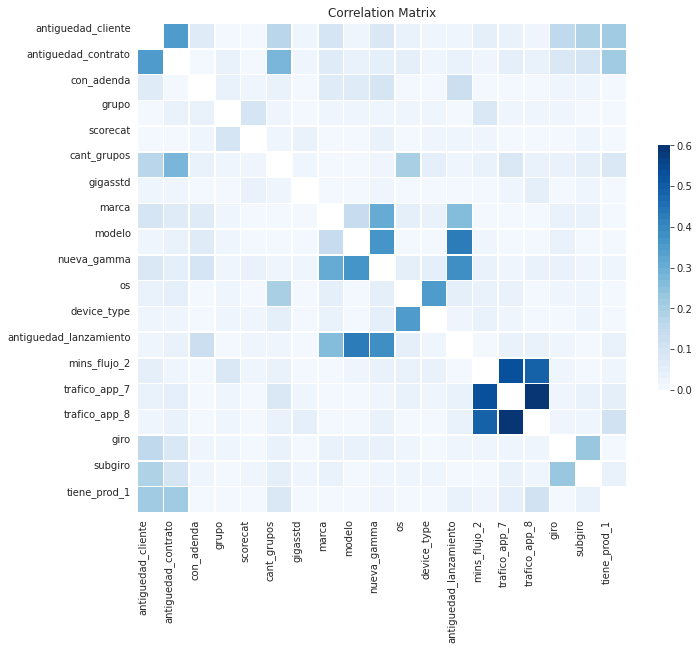

In [46]:
analysis4.stats("features")

In [47]:
analysis4.stats("metrics")

                         GRMlab Model Analysis                       

 Metrics
              Actual values
 P           1      |       0                Precision        Lift
 r    -----------------------------
 e 1 | TP:     4014 | FP:     1509           0.72678          1.49134
 d   | TPR: 0.75879 | FPR: 0.27116
 i    -----------------------------
 c 0 | FN:     1276 | TN:     4056           0.76069          1.48379
 t   | FNR: 0.24121 | TNR: 0.72884
 e   ------------------------------
 d
     Accuracy       0.74344
     Youden Index   0.48763

     Gini                   0.63677 +/- 0.01298 (95%); std: 0.0066230
     Matthews Corr. Coef.   0.48755 +/- 0.01348 (95%); std: 0.0068780
     Cohen Kappa            0.48710 +/- 0.01348 (95%); std: 0.0068754

     Log-loss       0.98667
   --------------------------------------------------------------------------



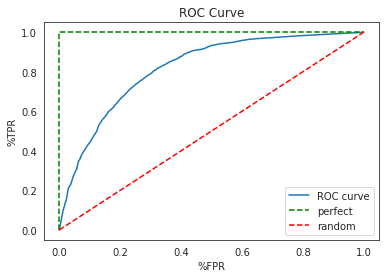

In [48]:
analysis4.plot_roc()

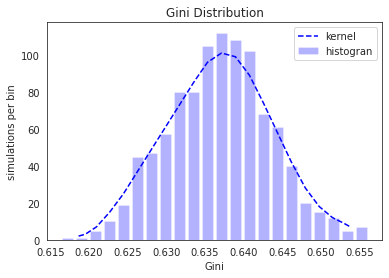

In [49]:
analysis4.metric_plot_descriptive("gini", "hist", 1.5)

In [59]:
X_test=df_woe_test[select_var]
y_test=df_woe_test['target']
y_test_predict = model4.predict_proba(X_test)[:,1]

In [60]:
from sklearn.metrics import auc, recall_score
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
import yaml
import glob
import seaborn as sns
import unicodedata

from scipy.stats import ks_2samp

def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic

def predicciones (df_test_y, probs_):
  
    predictions_xgb_01 = np.where(probs_ > 0.5, 1, 0)
    
    #preds = probs
    fpr, tpr, threshold = roc_curve(df_test_y, probs_)
    roc_auc= auc(fpr, tpr)
    gini = 2*roc_auc-1
    
    return roc_auc, gini,recall_score(df_test_y, predictions_xgb_01), ks_stat(df_test_y,probs_)

def Grafica_PD(data,periodo,ventiles=20,model_name='Regresión Logística'):
  plt.figure(figsize=(20,8))
  #df_pred=data.copy()
  #dt_cat_p=df_pred[df_pred['periodo']==periodo].copy()
  dt_cat_p=data.copy()
  dt_cat_p['ventil'] = pd.qcut(dt_cat_p['pred'].rank(method='first'), ventiles, labels=False)
  aa=dt_cat_p.groupby(['ventil','real'])['pred'].count().reset_index()
  b=aa[aa['real']==0]['pred']
  c=aa[aa['real']==1]
  d=dt_cat_p.groupby(['ventil'])['pred'].count().reset_index().rename(columns={'pred':'total'})
  yy=c.reset_index(drop=True).merge(d,how='left',on='ventil')
  yy['pd']=yy['pred']/yy['total']
  ax=sns.barplot(x="ventil", y="pd", data=yy)
  ax.set_title(model_name+' '+ str(periodo))
  display(ax)
  
def Matriz_PD(data,periodo,ventiles=20,model_name='Regresión Logística'):
  plt.figure(figsize=(20,8))
  #df_pred=data.copy()
  #dt_cat_p=df_pred[df_pred['periodo']==periodo].copy()
  dt_cat_p=data.copy()
  dt_cat_p['ventil'] = pd.qcut(dt_cat_p['pred'].rank(method='first'), ventiles, labels=False)
  aa=dt_cat_p.groupby(['ventil','real'])['pred'].count().reset_index()
  b=aa[aa['real']==0]['pred']
  c=aa[aa['real']==1]
  d=dt_cat_p.groupby(['ventil'])['pred'].count().reset_index().rename(columns={'pred':'total'})
  yy=c.reset_index(drop=True).merge(d,how='left',on='ventil')
  yy['pd']=yy['pred']/yy['total']
  return yy

In [62]:
predicciones(y_test, y_test_predict)

(0.5091075130636582,
 0.018215026127316403,
 0.5919811320754716,
 0.04277664431148445)

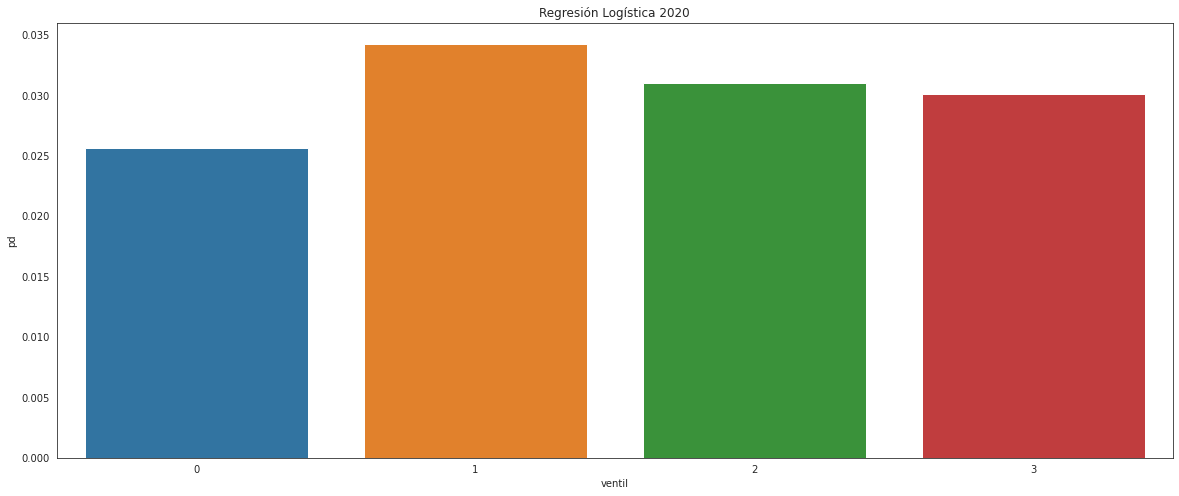

In [68]:
X_test['pred']=y_test_predict
X_test['real']=y_test
Grafica_PD(X_test,2020,ventiles=4)

In [69]:
a=Matriz_PD(X_test,201906,ventiles=4)
a['pd']=a['pd']*100
a

,ventil,real,pred,total,pd
0,0,1,1169,45536,2.567200
1,1,1,1561,45536,3.428057
2,2,1,1412,45536,3.100843
3,3,1,1370,45536,3.008609


<Figure size 1440x576 with 0 Axes>

In [80]:
dt_cat_p=X_test.copy()
dt_cat_p['ventil'] = pd.qcut(dt_cat_p['pred'].rank(method='first'), 4, labels=False)

,ventil,buenos,malos,total,malos/total,min,max,mean,malos_/total,porc_total,cumsum_porc_total,cumsum_total,filter_rs
0,0,44367,1169,45536,2.567200,0.000,33.75,16.894,2.5672,0.25,0.25,45536,r1-r3
1,1,43975,1561,45536,3.428057,33.833,59.00,46.748,3.4281,0.25,0.50,91072,r1-r3
2,2,44124,1412,45536,3.100843,59.000,77.75,68.472,3.1008,0.25,0.75,136608,r4-r6
3,3,44166,1370,45536,3.008609,77.750,100.00,89.515,3.0086,0.25,1.00,182144,r4-r6


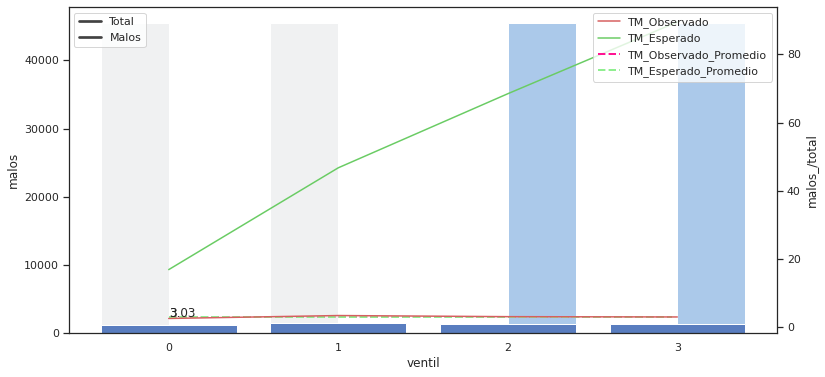

In [81]:
plot_tm(df=dt_cat_p,var='pred',target='real',numdecil=4,ref2=3,var_decil='ventil')

In [76]:
dt_cat_p.columns

Index(['tipo_adq', 'antiguedad_cliente', 'antiguedad_contrato',
       'antiguedad_cliente_contrato', 'vchmesadenda', 'vchpenalidad',
       'con_adenda', 'grupo', 'scorecat', 'grupo_1', 'grupo_2', 'grupo_3',
       'grupo_4', 'grupo_5', 'grupo_6', 'grupo_7', 'grupo_8', 'grupo_9',
       'grupo_10', 'grupo_11', 'cant_grupos', 'tiposerviciocount',
       'minutossum', 'minutosmean', 'mensajessum', 'gigassum', 'gigasmean',
       'gigasstd', 'max_tiempo_interaccion', 'tiposervicio', 'marca', 'modelo',
       'nueva_gamma', 'os', 'device_type', 'antiguedad_lanzamiento',
       'mins_flujo_1', 'mins_flujo_2', 'trafico_app_1', 'trafico_app_2',
       'trafico_app_3', 'trafico_app_4', 'trafico_app_5', 'trafico_app_6',
       'trafico_app_7', 'trafico_app_8', 'trafico_app_9', 'trafico_total',
       'giro', 'subgiro', 'tiene_prod_1', 'tiene_prod_2', 'tiene_prod_3',
       'target', 'pred', 'real', 'ventil'],
      dtype='object')

In [77]:
def plot_tm(df,var,target,numdecil,ref2,var_decil):
    
    import pandas as pd
    import math
    import pandas as pd
    import numpy as np
    import seaborn as sns

 

    df_bivariado = df.groupby([var_decil,target],as_index=False).agg({var:['min','max','mean'],'scorecat':'count'})
    df_bivariado.columns = [var_decil,target,'min','max','mean','count']

 

    buenos = 'buenos'
    malos = 'malos'
    
    maximo = 'max'
    minimo = 'min'
    promedio = 'mean'
        
    df_pivot_min = df_bivariado.pivot(var_decil, target, 'min').fillna(0)
    df_pivot_min = df_pivot_min.rename(columns={0:buenos,1:minimo})
    df_pivot_min = df_pivot_min.reset_index()
    df_min = df_pivot_min[[var_decil,minimo]]
    
    df_pivot_max = df_bivariado.pivot(var_decil, target, 'max').fillna(0)
    df_pivot_max = df_pivot_max.rename(columns={0:buenos,1:maximo})
    df_pivot_max = df_pivot_max.reset_index()
    df_max = df_pivot_max[[var_decil,maximo]]
    
    df_pivot_mean = df_bivariado.pivot(var_decil, target, 'mean').fillna(0)
    df_pivot_mean = df_pivot_mean.rename(columns={0:buenos,1:promedio})
    df_pivot_mean = df_pivot_mean.reset_index()
    df_mean = df_pivot_mean[[var_decil,promedio]]
    
    df_min_max = pd.merge(left=df_min,right=df_max, on=[var_decil],how='inner')
    df_min_max_mean = pd.merge(left=df_min_max,right=df_mean, on=[var_decil],how='inner')
    
    df_pivot = df_bivariado.pivot(var_decil, target, 'count').fillna(0)
    df_pivot.columns = ['buenos','malos']
    
    df_pivot['total'] = df_pivot[buenos] + df_pivot[malos]
    df_resumen = df_pivot.reset_index()
    df_resumen['malos/total']=100*df_resumen[malos]/df_resumen.total
    df_resumen = pd.merge(left=df_resumen,right=df_min_max_mean, on=[var_decil],how='inner')
    
    df_resumen['malos_/total']=np.round(df_resumen['malos/total'].values,4)
    
    trunc = lambda x: math.trunc(1000 * x) / 1000;
    
    df_resumen['min'] = 100*df_resumen['min'];  df_resumen['min'] = df_resumen[['min']].applymap(trunc)
    df_resumen['max'] = 100*df_resumen['max'];  df_resumen['max'] = df_resumen[['max']].applymap(trunc)
    df_resumen['mean'] = 100*df_resumen['mean']; df_resumen['mean'] = df_resumen[['mean']].applymap(trunc)
    
    df_resumen['porc_total'] = df_resumen['total']/df_resumen['total'].sum()
    
    import numpy as np
    df_resumen['cumsum_porc_total'] = np.cumsum(df_resumen['porc_total'])
    df_resumen['cumsum_total'] = np.cumsum(df_resumen['total'])
    
    df_resumen['filter_rs'] = np.where(df_resumen['cumsum_porc_total']<0.72,'r1-r3','r4-r6')
    
    df_resumen[var_decil] = df_resumen[var_decil].astype('int')
    ref = np.round(100*(df_resumen[malos].sum()/df_resumen['total'].sum()),2)
     
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set(style="white")
    
    f, ax = plt.subplots(nrows=1, ncols=1)
    f.set_figwidth(12.7)
    f.set_figheight(6)
    sns.set_color_codes("pastel")
    sns.barplot(y="total", x=var_decil, data=df_resumen,hue="filter_rs", color="b",ax=ax)
    sns.set_color_codes("muted")
    sns.barplot(y=malos, x=var_decil, data=df_resumen,color="b",ax=ax)
    
    ax.grid(False)
    ax.legend(ncol=1, loc="best", frameon=True)
    
    
    sns.despine(left=True, bottom=True)
    
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.hlines(y=ref, xmin=df_resumen[var_decil].min()*0.95, xmax=df_resumen[var_decil].max()*0.99, linewidth=2, color='deeppink',linestyles='--')
    ax2.text(0, ref+1, str(ref), ha='left', va='center')
    ax2.hlines(y=ref2, xmin=df_resumen[var_decil].min()*0.95, xmax=df_resumen[var_decil].max()*0.99, linewidth=2, color='lightgreen',linestyles='--')
    ax2.text(0, ref2+1, str(ref2), ha='left', va='center')
    
    
    sns.lineplot(y="malos_/total", x=var_decil, data=df_resumen,color='r',ax=ax2)
    sns.lineplot(y="mean", x=var_decil, data=df_resumen,color='g',ax=ax2)
    
    ax2.legend(labels=['TM_Observado', 'TM_Esperado','TM_Observado_Promedio','TM_Esperado_Promedio' ],loc='upper right')
    ax.legend(labels=['Total', 'Malos', ],loc='upper left')
    
    return df_resumen
    
def create_rs(df,fronteras):
    len0 = 0;len1=0;len2=0; rangos_riesgos = []
    for row in range(len(df)):
        totales = df.loc[df.index[0:row+1],["malos","total"]].sum()
        porc_malos_inicial = totales['malos']/totales['total']
        if porc_malos_inicial<fronteras[0]:
            len0 += 1
            riesgo = 'R1'
            porc_malos = porc_malos_inicial
        elif porc_malos<fronteras[1]:
            totales = df.loc[df.index[len0:row+1],["malos","total"]].sum()
            porc_malos = totales['malos']/totales['total']
            riesgo = 'R2'
            len1 += 1
        elif porc_malos<fronteras[2]:
            totales = df.loc[df.index[len0+len1:row+1],["malos","total"]].sum()
            porc_malos = totales['malos']/totales['total']
            riesgo = 'R3'
            len2 += 1
        elif row<=47:
            totales = df.loc[df.index[len0+len1+len2:row+1],["malos","total"]].sum()
            porc_malos = totales['malos']/totales['total']
            riesgo = 'R4'
        elif row<=53:
            totales = df.loc[df.index[len0+len1:row+1],["malos","total"]].sum()
            porc_malos = totales['malos']/totales['total']
            riesgo = 'R5'
        else:
            riesgo = 'R6'
            
        rangos_riesgos.append(riesgo)

 

    df['Rs'] = rangos_riesgos
    df_report = df.groupby(['Rs'],as_index=False).agg({'min':min,'max':max,'malos':sum,'total':sum})
    df_report['TM_Observada'] = df_report['malos']/df_report['total']
    return df_report, df